In [1]:
import numpy as np
import os
import cv2
import sys
import matplotlib
import matplotlib.pyplot as plt
from tifffile import imread
from glob import glob
import math
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from hmmlearn import hmm

sys.path.append("/home/cstansbu/.local/lib/python3.9/site-packages/")
from pomegranate.distributions import Categorical
from pomegranate.hmm import DenseHMM
from pomegranate.hmm import SparseHMM
import pymc3 as pm
import scipy
from scipy import interpolate
from skimage import data, segmentation, feature, future
import pandas as pd
import skimage
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

import utils as ut
from importlib import reload 
reload(ut)

sys.path.append("/home/cstansbu/BayesianTracker/")
import btrack

2023-05-11 12:51:24.689219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 12:51:34.871919: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-11 12:51:48.125678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cstansbu/.local/lib/python3.9/site-packages/cv2/../../lib64:/opt/slurm/lib64:
2023-05-11 12:51:48.126567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

In [2]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/wh17/composite.tif"

im = imread(fpath)
print(f"{im.shape=}")

im.shape=(49, 1329, 1801, 3)


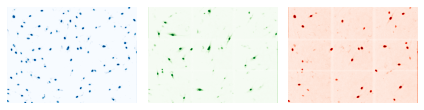

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

t = 20

axs[0].imshow(im[t, :, :, 2], cmap='Blues')
axs[0].axis(False)

axs[1].imshow(im[t, :, :, 1], cmap='Greens')
axs[1].axis(False)

axs[2].imshow(im[t, :, :, 0], cmap='Reds')
axs[2].axis(False)

plt.tight_layout()

In [4]:
reload(ut)
p = 0.65 # probability for segementation, high is more strict

model = StarDist2D.from_pretrained('2D_versatile_fluo')

cellTable = []
segments = {}

for t in range(len(im)):
    
    nuc = im[t, :, :, 2]
    green = im[t, :, :, 1]
    red = im[t, :, :, 0]
    
    intensity = im[t, :, :, :]
    print(intensity.shape)
    
    nucLabels, _ = model.predict_instances(normalize(nuc), prob_thresh=p)
    # greenLabels, _ = model.predict_instances(normalize(green), prob_thresh=p)
    # redLabels, _ = model.predict_instances(normalize(red), prob_thresh=p)
    
    segments[t] = nucLabels
    
    # cell properties based on nucleus only
    props = skimage.measure.regionprops(nucLabels, intensity_image=intensity)
    pdf = ut.getRegionPropsTable(props)
    pdf['time'] = t
    cellTable.append(pdf)
    

cdf = pd.concat(cellTable)
print(f"{cdf.shape=}")
cdf.head()

Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-05-11 12:52:05.584872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cstansbu/.local/lib/python3.9/site-packages/cv2/../../lib64:/opt/slurm/lib64:
2023-05-11 12:52:05.604082: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 12:52:05.604123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3234.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2023-05-11 12:52:05.605800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
(1329, 1801, 3)
1/1 [==============================] - 3s 3s/step
(1329, 1801, 3)
1/1 [==============================] - 0s 479ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 454ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 458ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 452ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 464ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 477ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 455ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 457ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 453ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 452ms/step
(1329, 1801, 3)
1/1 [==============================] - 0s 469ms/step
(1329, 1801, 3)
1/1 [===

area  area_convex  area_filled  axis_major_length  axis_minor_length   
0  480.0        501.0        480.0          27.821894          21.992586  \
1  475.0        489.0        475.0          28.332526          21.354160   
2  765.0        788.0        765.0          36.300817          26.897645   
3  790.0        817.0        790.0          35.620831          28.787952   
4  514.0        531.0        514.0          27.332449          24.048186   

    centroid_y   centroid_x  eccentricity   
0  1038.972917  1048.175000      0.612491  \
1    38.446316  1476.938947      0.657221   
2   565.577778   783.917647      0.671543   
3   550.615190  1436.305063      0.588939   
4   749.322957   612.453307      0.475270   

                                           intensity          intensity_max   
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  [107.0, 255.0, 255.0]  \
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  [255.0, 255.0, 255.0]   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  [127.0, 255.0, 255.0]   
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  [134.0, 255.0, 255.0]   
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   [92.0, 139.0, 255.0]   

        intensity_min                                     intensity_mean   
0  [0.0, 162.0, 50.0]  [28.858333333333334, 254.74166666666667, 222.6...  \
1  [0.0, 112.0, 62.0]  [173.22105263157894, 247.44842105263157, 229.3...   
2    [0.0, 3.0, 41.0]  [22.394771241830064, 226.3843137254902, 235.20...   
3   [0.0, 43.0, 68.0]  [24.435443037974682, 246.57341772151898, 240.7...   
4    [0.0, 0.0, 41.0]  [15.542801556420233, 62.811284046692606, 230.0...   

   label  orientation   perimeter  solidity   
0      1    -0.196206   80.769553  0.958084  \
1      2    -0.524532   79.355339  0.971370   
2      3    -1.085565  103.154329  0.970812   
3      4     1.311952  106.083261  0.966952   
4      5    -1.532343   82.769553  0.967985   

                                               slice  circularity  time  
0  (slice(1026, 1053, None), slice(1037, 1060, No...     0.924604     0  
1     (slice(26, 52, None), slice(1466, 1489, None))     0.947875     0  
2     (slice(551, 581, None), slice(767, 802, None))     0.903434     0  
3   (slice(535, 565, None), slice(1421, 1456, None))     0.882152     0  
4     (slice(738, 762, None), slice(600, 627, None))     0.942826     0

In [5]:
test = im.copy()

nuc = test[:, :, :, 2]

print(f"{test.shape=} {nuc.shape=}")

# dir(model)
print(model._axes_out)

# labels, _ = model.predict_instances(normalize(test), axes="TC", prob_thresh=p)

test.shape=(49, 1329, 1801, 3) nuc.shape=(49, 1329, 1801)
YXC


In [6]:
?model.predict_instances

Signature:
model.predict_instances(
    img,
    axes=None,
    normalizer=None,
    sparse=True,
    prob_thresh=None,
    nms_thresh=None,
    scale=None,
    n_tiles=None,
    show_tile_progress=True,
    verbose=False,
    return_labels=True,
    predict_kwargs=None,
    nms_kwargs=None,
    overlap_label=None,
    return_predict=False,
)
Docstring:
Predict instance segmentation from input image.

Parameters
----------
img : :class:`numpy.ndarray`
    Input image
axes : str or None
    Axes of the input ``img``.
    ``None`` denotes that axes of img are the same as denoted in the config.
normalizer : :class:`csbdeep.data.Normalizer` or None
    (Optional) normalization of input image before prediction.
    Note that the default (``None``) assumes ``img`` to be already normalized.
sparse: bool
    If true, aggregate probabilities/distances sparsely during tiled
    prediction to save memory (recommended).
prob_thresh : float or None
    Consider only object candidates from pixels wi

In [7]:
# break

In [8]:
?model.predict_instances

Signature:
model.predict_instances(
    img,
    axes=None,
    normalizer=None,
    sparse=True,
    prob_thresh=None,
    nms_thresh=None,
    scale=None,
    n_tiles=None,
    show_tile_progress=True,
    verbose=False,
    return_labels=True,
    predict_kwargs=None,
    nms_kwargs=None,
    overlap_label=None,
    return_predict=False,
)
Docstring:
Predict instance segmentation from input image.

Parameters
----------
img : :class:`numpy.ndarray`
    Input image
axes : str or None
    Axes of the input ``img``.
    ``None`` denotes that axes of img are the same as denoted in the config.
normalizer : :class:`csbdeep.data.Normalizer` or None
    (Optional) normalization of input image before prediction.
    Note that the default (``None``) assumes ``img`` to be already normalized.
sparse: bool
    If true, aggregate probabilities/distances sparsely during tiled
    prediction to save memory (recommended).
prob_thresh : float or None
    Consider only object candidates from pixels wi

In [9]:
# break

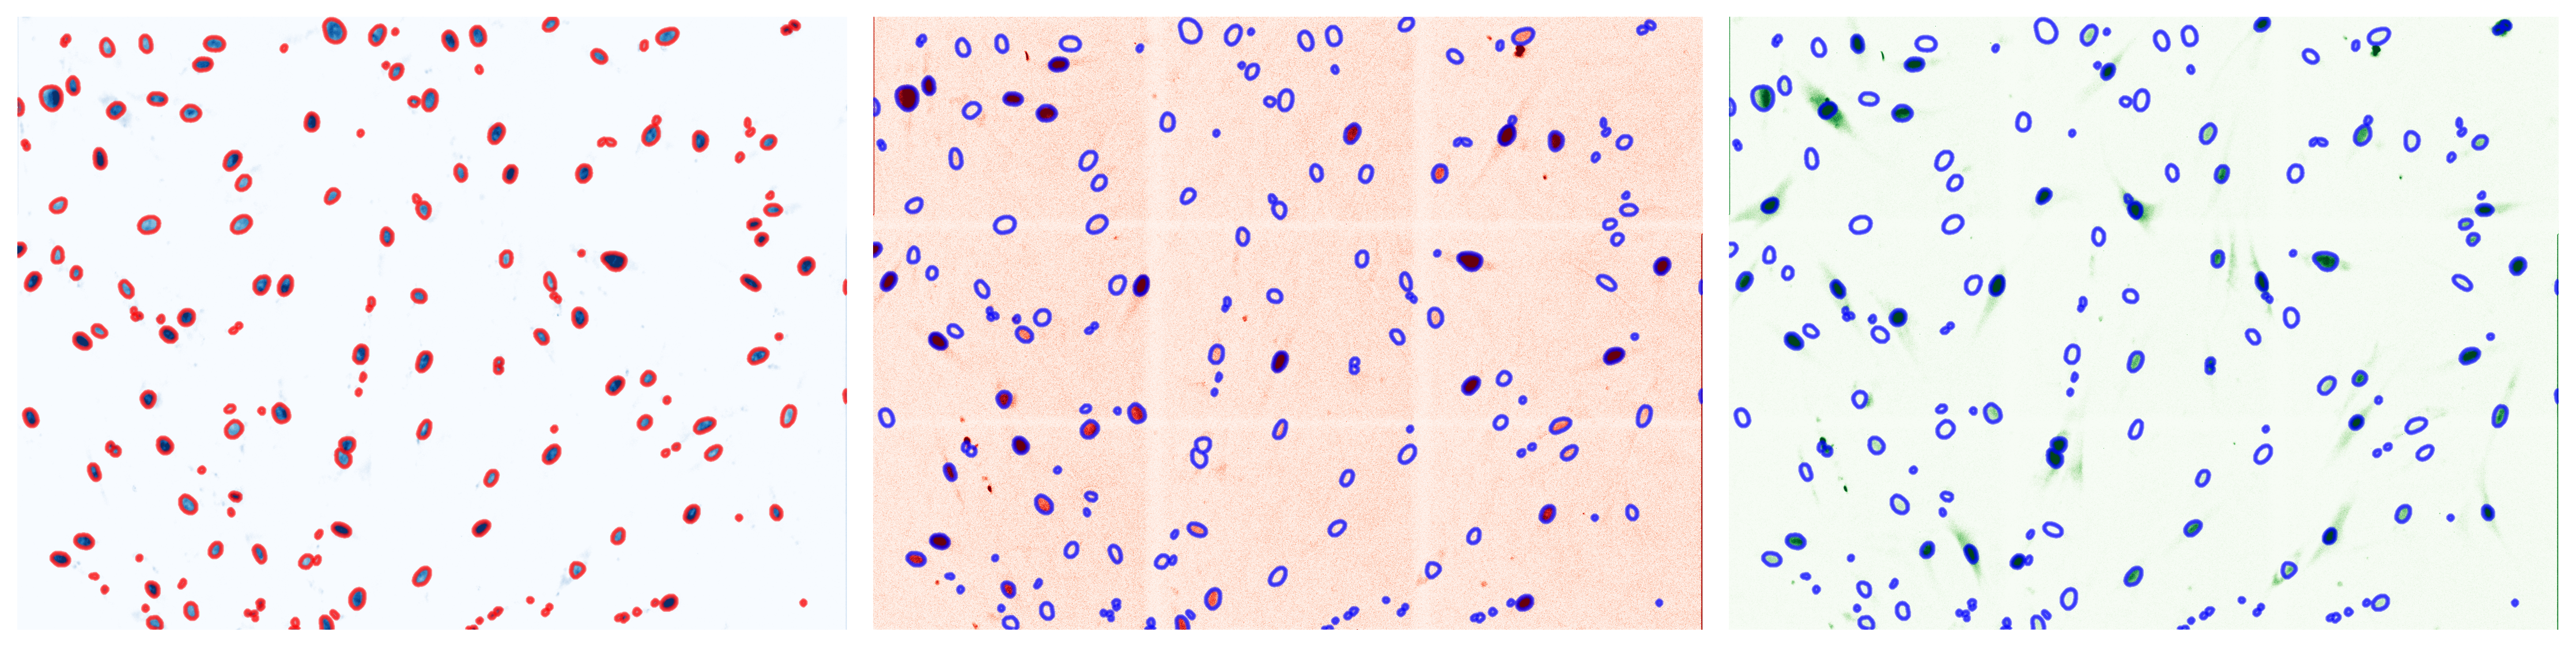

In [10]:
t = 38

label = segments[t]
bounds = skimage.segmentation.find_boundaries(label)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 15, 5
fig, axs = plt.subplots(1, 3)


# axs[0].imshow(label, cmap='Blues',vmin=0, vmax=1.3)
axs[0].imshow(im[t, :, :, 2], cmap='Blues')
axs[0].contour(bounds, levels=1, colors=['r'], alpha=0.3,  zorder=2)
axs[0].axis(False)

axs[1].imshow(im[t, :, :, 0], cmap='Reds')
axs[1].contour(bounds, levels=1, colors=['b'], alpha=0.3,  zorder=2)
axs[1].axis(False)

axs[2].imshow(im[t, :, :, 1], cmap='Greens')
axs[2].contour(bounds, levels=1, colors=['b'], alpha=0.3,  zorder=2)
axs[2].axis(False)

plt.tight_layout()

Index(['time', 'ncells', 'area', 'ratio'], dtype='object')


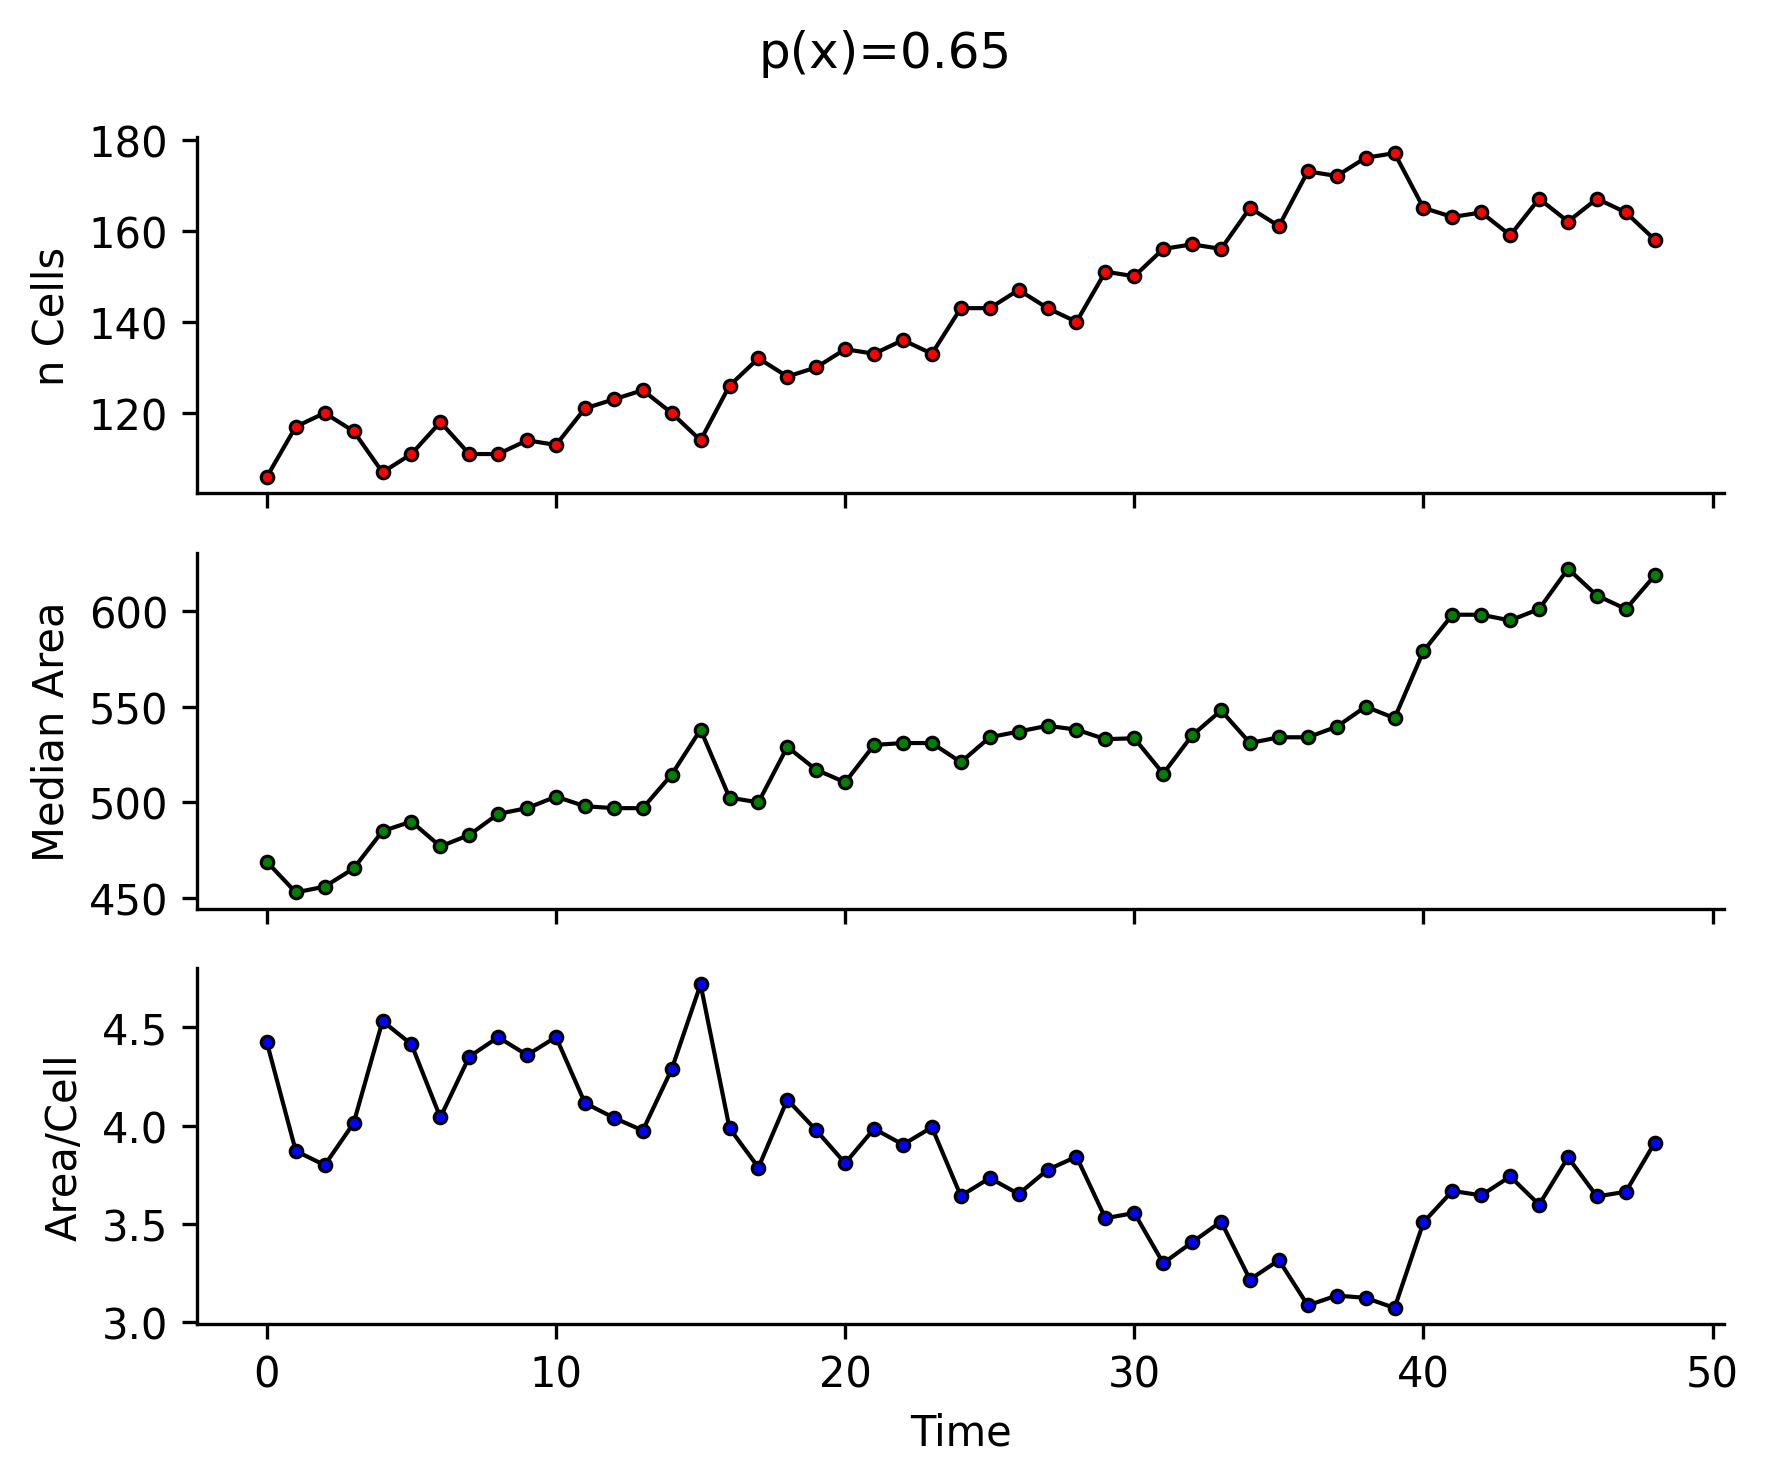

In [11]:
# plot the number of cells over time
gx = cdf.groupby('time').agg(
    ncells = ('label', 'count'),
    area = ('area', np.median),
).reset_index()

gx['ratio'] = gx['area'] / gx['ncells']
gx = gx.astype(float)

print(gx.columns)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 5
fig, axs = plt.subplots(3, 1, sharex=True)

sns.lineplot(data=gx, 
            x='time',
            y='ncells',
            marker='.',
            lw=1,
            color='k',
            markeredgecolor='k',
            markerfacecolor='r',
            ax=axs[0])

axs[0].set_ylabel(f'n Cells')
axs[0].set_xlabel('')

sns.lineplot(data=gx, 
            x='time',
            y='area',
            marker='.',
            lw=1,
            color='k',
            markeredgecolor='k',
            markerfacecolor='g',
            ax=axs[1])

axs[1].set_ylabel(f'Median Area') 

sns.lineplot(data=gx, 
            x='time',
            y='ratio',
            marker='.',
            lw=1,
            color='k',
            markeredgecolor='k',
            markerfacecolor='b',
            ax=axs[2])

axs[2].set_ylabel(f'Area/Cell') 

plt.xlabel('Time')
plt.suptitle(f"p(x)={p}")
sns.despine()
plt.tight_layout()

In [12]:
# estimate phases statistically, first build the time-dependant background
# unravel the whole image for each channel at each time point
def getIntensities(im, labels=None):
    """Expects (time, y, x, channel). If labels are passed, 
    the image will be masked at each time point to exclude cell regions from background intensity"""
    t, y, x, c = im.shape
    xy = x * y
    im2 = im.reshape(t, xy, c)
    if labels is None:
        return im2
    else:
        labelIm2 = labels.reshape(t, xy)
        mask = np.where(labelIm2 > 0, 1, 0)
        mask_3d = np.stack((mask,mask,mask),axis=2) #3 channel mask
        im2 = np.where(mask_3d==1,im2, np.nan)
        return im2
        

labelIm = np.asarray([segments[i] for i in range(49)])
print(f"{labelIm.shape=}") # labels

# intensities = getIntensities(im, labelIm)  
intensities = getIntensities(im)  
print(f"{intensities.shape=}") # background intensities

intesityStats = {}

for t in range(intensities.shape[0]):
    for c in [0, 1, 2]: # hand-picked channels
        H = intensities[t, :, c]
        
        Hmu = np.nanmean(H)
        Hsigma = np.nanstd(H)
        Hn = H.size
        intesityStats[t, c] = [Hmu, Hsigma, Hn]
        
print('done')    

labelIm.shape=(49, 1329, 1801)
intensities.shape=(49, 2393529, 3)
done


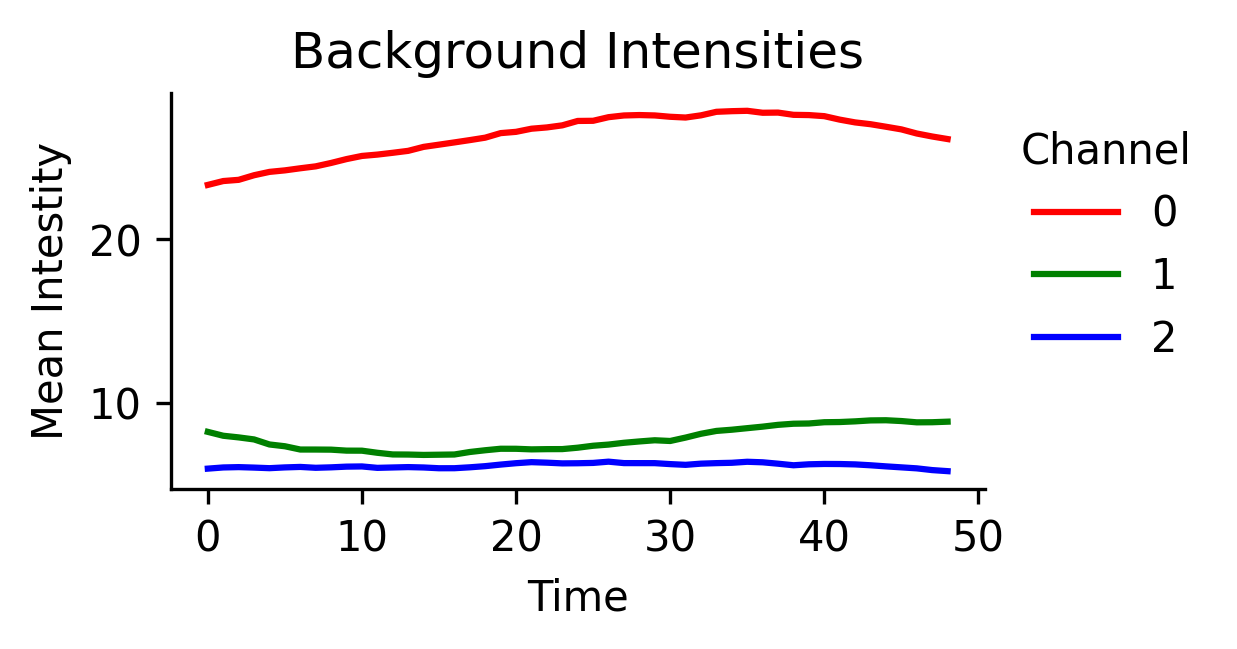

In [13]:
## get a dataframe of intensities over time
idf = pd.DataFrame.from_dict(intesityStats, orient='index')
idf.columns = ['mean', 'std', 'n']
idf = idf.reset_index(drop=False)
idf2 = pd.DataFrame(idf['index'].tolist(), index=idf.index)
idf2.columns = ['t', 'c']
idf = pd.concat([idf, idf2], axis=1)
idf = idf.drop(columns='index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3.5, 1.75

sns.lineplot(data=idf, 
             x='t',
             y='mean',
             hue='c',
             palette=['r', 'g', 'b'])

sns.move_legend(plt.gca(), 
               title="Channel",
               frameon=False,
               loc='upper right',
               bbox_to_anchor=(1.3, 1))

plt.ylabel('Mean Intestity')
plt.xlabel('Time')
plt.title('Background Intensities')
sns.despine()


In [14]:
scores = []

def unfold(image):
    """ unravel the segmentation intensities """
    y, x, c = image.shape
    xy = x*y
    image2 = image.reshape(xy, c)
    return image2


def testIntensities(cdf, intensities):
    """A function to statistically test the presence of flourescent 
    markers """
    
    scores = []

    for idx, row in cdf.iterrows():
        t = row['time']
        label = row['label']
        h = row['unfolded']
        
        """ from descriptive stats """
        newRow = []
        
        for c in [0, 1, 2]:
            hmu = np.mean(h[:, c])
            hsigma = np.std(h[:, c])
            hn = h[:, c].size
            
            Hmu, Hsigma, Hn = intesityStats[t, c]
            
            _, pval = scipy.stats.ttest_ind_from_stats(hmu, hsigma, hn, 
                                                       Hmu, Hsigma, Hn, 
                                                       equal_var=False, 
                                                       alternative='greater')
            newRow.append(pval)
            

        newRow = newRow + [t, label]
        
        # """ From the images directly: much slower! """
        # H = intensities[t, :, 0:2] # time-dependant background
        # # a single function call per image
        # _, pvals = scipy.stats.ttest_ind(h, H, axis=0,
        #                                  equal_var=False,
        #                                  alternative='greater')

        # newRow = np.concatenate([pvals, [t, label]])
        scores.append(newRow)
        
    return scores
    
# unfold the intensity tensors
cdf['unfolded'] = cdf['intensity'].apply(lambda x: unfold(x))

# score the other channels
scores = testIntensities(cdf, intensities)    
scores = pd.DataFrame(scores, columns=['red_pval', 'green_pval', 'blue_pval', 'time', 'label'])
print(scores.head())

""" This shows how much faster descriptive stats are...."""
# %load_ext line_profiler
# %lprun -f testIntensities testIntensities(cdf, intensities)    

        red_pval     green_pval      blue_pval  time  label
0   8.540658e-01  2.559879e-193  5.783094e-178     0      1
1  1.871579e-129  5.609083e-195  3.058232e-183     0      2
2   1.000000e+00  1.309110e-254  7.258645e-270     0      3
3   1.000000e+00  2.635395e-296  9.805707e-293     0      4
4   1.000000e+00  9.868718e-123  2.264210e-195     0      5


' This shows how much faster descriptive stats are....'

In [15]:
# break

In [16]:
alpha = 0.001
ntests = len(scores) * 3 # number of times times channels
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

scores['red_pass'] = np.where(scores['red_pval'] <= alphaHat, 1, 0)
scores['green_pass'] = np.where(scores['green_pval'] <= alphaHat, 1, 0)

scores['pfMap'] = scores['red_pass'].astype(str) + scores['green_pass'].astype(str)

pfMap = {
    '01' : "G1",
    '10' : 'S',
    '11' : 'G2',
}

scores['phase'] = scores['pfMap'].map(pfMap)
print(scores['phase'].value_counts())
print()
scores.head()

alpha=0.001 ntests=20634 4.8487947545972077e-08
phase
G1    2041
G2    1406
S      496
Name: count, dtype: int64



red_pval     green_pval      blue_pval  time  label  red_pass   
0   8.540658e-01  2.559879e-193  5.783094e-178     0      1         0  \
1  1.871579e-129  5.609083e-195  3.058232e-183     0      2         1   
2   1.000000e+00  1.309110e-254  7.258645e-270     0      3         0   
3   1.000000e+00  2.635395e-296  9.805707e-293     0      4         0   
4   1.000000e+00  9.868718e-123  2.264210e-195     0      5         0   

   green_pass pfMap phase  
0           1    01    G1  
1           1    11    G2  
2           1    01    G1  
3           1    01    G1  
4           1    01    G1

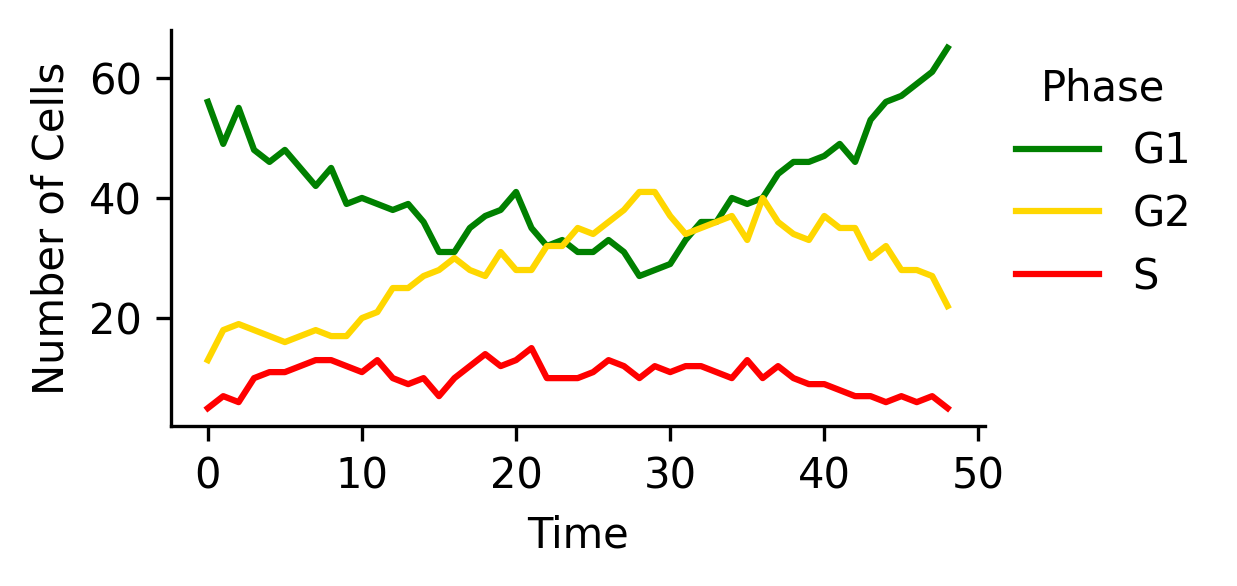

In [17]:
# count the phases over time 

gx = scores.groupby(['time', 'phase'])['label'].count().reset_index()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3.5, 1.75

sns.lineplot(data=gx, 
             x='time',
             y='label',
             palette=['g', 'gold', 'r'],
             hue='phase')

sns.move_legend(plt.gca(), 
               title="Phase",
               frameon=False,
               loc='upper right',
               bbox_to_anchor=(1.3, 1))

plt.ylabel('Number of Cells')
plt.xlabel('Time')
sns.despine()

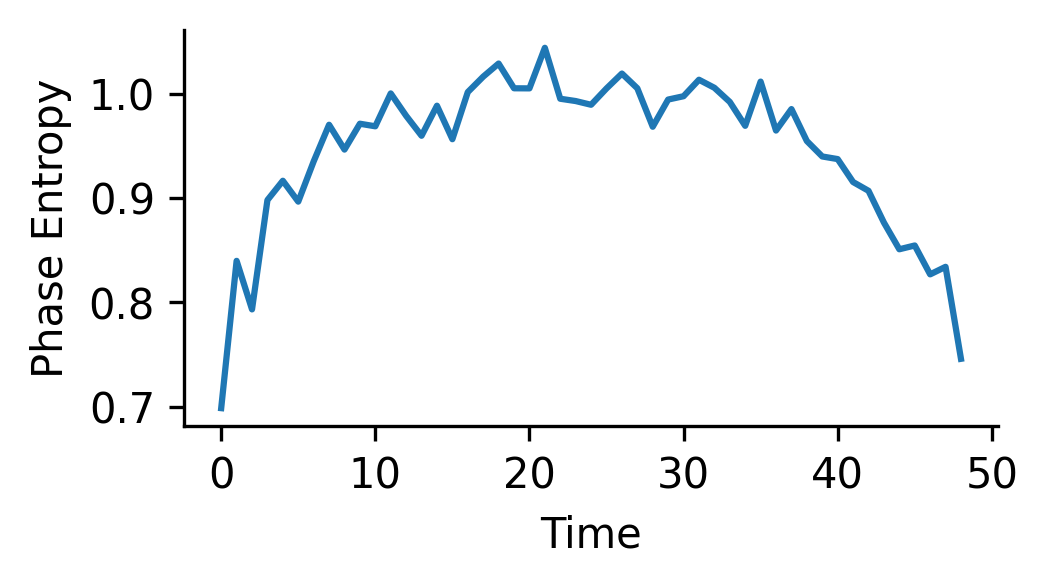

In [18]:
# compute instant entropy
gx = scores.groupby(['time', 'phase'])['label'].count().reset_index()
gx.columns = ['time', 'phase', 'count']

gx = pd.pivot_table(gx, index='time', columns=['phase'], values='count').reset_index(drop=False)
gx['n'] = gx[['G1', 'S', 'G2']].sum(axis=1)

def instant_entropy(row, states):
    """ Compute instantaneous entropy based on mixture of 
    cell phases """
    E = 0
    N = row['n']
    for st in states:
        E += (row[st]/N) * np.log((row[st]/N))  
    return -E

gx['instant_entropy'] = gx.apply(lambda x: instant_entropy(x, ['G1', 'S', 'G2']), axis=1)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3.5, 1.75

sns.lineplot(data=gx, 
             x='time',
             y='instant_entropy')

plt.ylabel('Phase Entropy')
plt.xlabel('Time')

sns.despine()

In [19]:
# gx = scores.copy()

# gx = pd.melt(gx, id_vars=['time'], 
#              value_vars = ['red_pval', 'green_pval']).reset_index(drop=False)

# sns.boxplot(data=gx, 
#              x='time', 
#              y='value',
#              palette=['r', 'g'],
#              # ec='None',
#              # s=1,
#              hue='variable')


# sns.move_legend(plt.gca(), 
#                title="Channel",
#                frameon=False,
#                loc='upper right',
#                bbox_to_anchor=(1.5, 1))

# # plt.yscale('log')
# plt.ylabel('p-value')
# plt.xlabel('Time')
# sns.despine()



In [20]:
scores.sample(5)

red_pval     green_pval      blue_pval  time  label  red_pass   
1562  9.376810e-173  8.635866e-105  1.812580e-186    13     75         1  \
4917   1.000000e+00  2.202745e-184  1.283755e-173    37     34         0   
1861  9.656827e-217  1.600825e-134  4.734143e-232    16     15         1   
5250  5.698864e-296  1.917224e-236  1.063064e-301    39     19         1   
2155   9.999997e-01  2.101354e-215  1.054168e-178    18     51         0   

      green_pass pfMap phase  
1562           1    11    G2  
4917           1    01    G1  
1861           1    11    G2  
5250           1    11    G2  
2155           1    01    G1

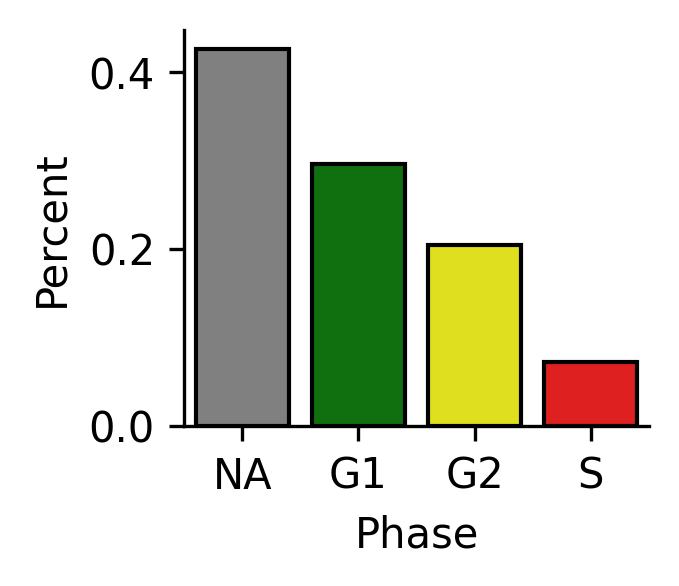

In [21]:
pdf = scores['phase'].value_counts(dropna=False, normalize=True).reset_index(drop=False)
pdf.columns = ['phase', 'count']
pdf = pdf.fillna("NA")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 2, 1.75

sns.barplot(data=pdf, 
            x='phase',
            ec='k',
            y='count',
            palette=['grey', 'g', 'yellow', 'r'])

plt.ylabel('Percent')
plt.xlabel('Phase')
sns.despine()

nan
xslice=slice(13, 34, None)
yslice=slice(1146, 1175, None)

xwin=slice(0, 234, None)
ywin=slice(946, 1375, None)



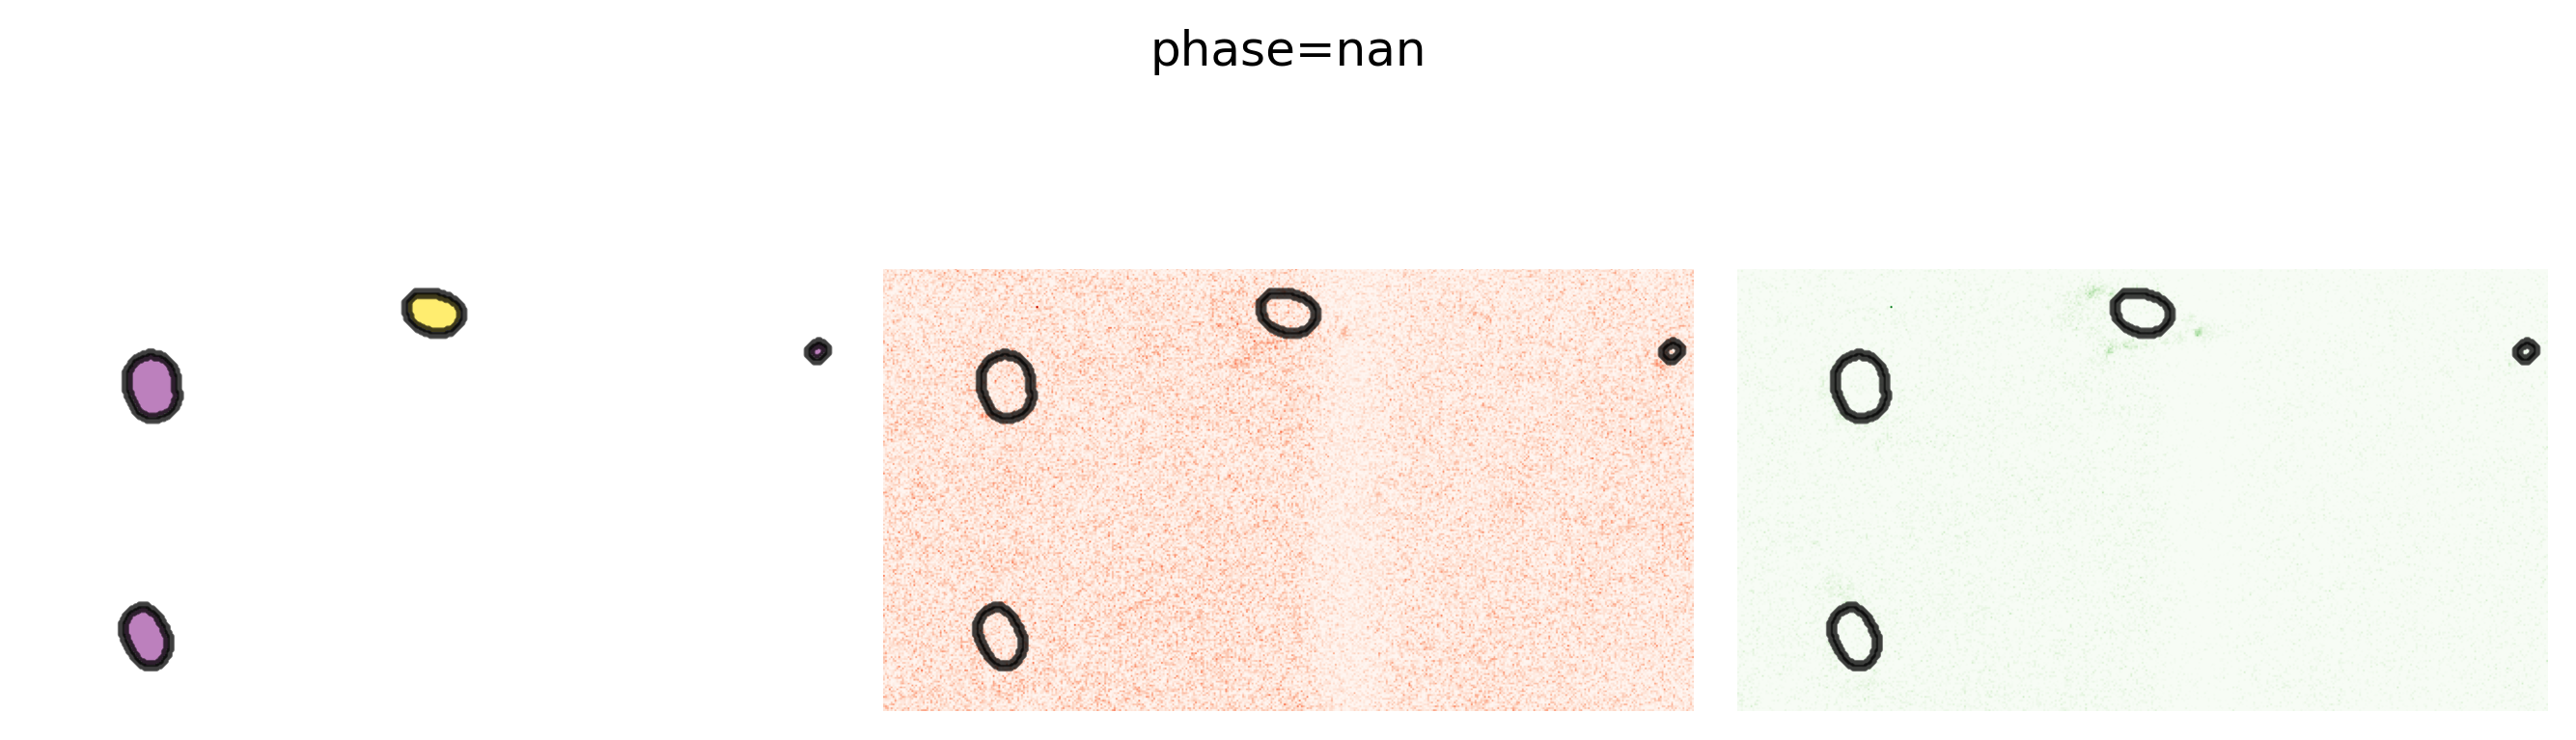

In [22]:
# t = 25
# label = 64

t, label, phase = scores.sample(1)[['time', 'label', 'phase']].values[0]
print(phase)

ws = 200

labels = segments[t]
bounds = skimage.segmentation.find_boundaries(labels)

labelimg = np.where(labels > 0, 1, np.nan)
labelimg = np.where(labels == label, 2, labelimg)


meta = cdf[(cdf['time'] == t) & (cdf['label'] == label)]

# widen the window
xslice, yslice = meta['slice'].values[0]

xmin = np.max([0, xslice.start - ws])
ymin = np.max([0, yslice.start - ws])

xwin = slice(xmin, xslice.stop + ws)
ywin = slice(ymin, yslice.stop + ws)

print(f"{xslice=}")
print(f"{yslice=}")
print()
print(f"{xwin=}")
print(f"{ywin=}")
print()

labels_binary = np.where(labels > 0, 1, np.nan)
labels_binary = np.where(labels == label, 2, labels_binary)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 9, 3
fig, axs = plt.subplots(1, 3)


axs[0].imshow(labelimg[xwin, ywin], 
              cmap='Set3',
              vmin=0, vmax=1.3)
axs[0].contour(bounds[xwin, ywin], levels=1, colors=['k'], alpha=0.5,  zorder=2)
axs[0].axis(False)

axs[1].imshow(im[t, xwin, ywin, 0], cmap='Reds')
axs[1].contour(bounds[xwin, ywin], levels=1, colors=['k'], alpha=0.5,  zorder=2)
axs[1].axis(False)

axs[2].imshow(im[t, xwin, ywin, 1], cmap='Greens')
axs[2].contour(bounds[xwin, ywin], levels=1, colors=['k'], alpha=0.5,  zorder=2)
axs[2].axis(False)

plt.suptitle(f"{phase=}")

plt.tight_layout()

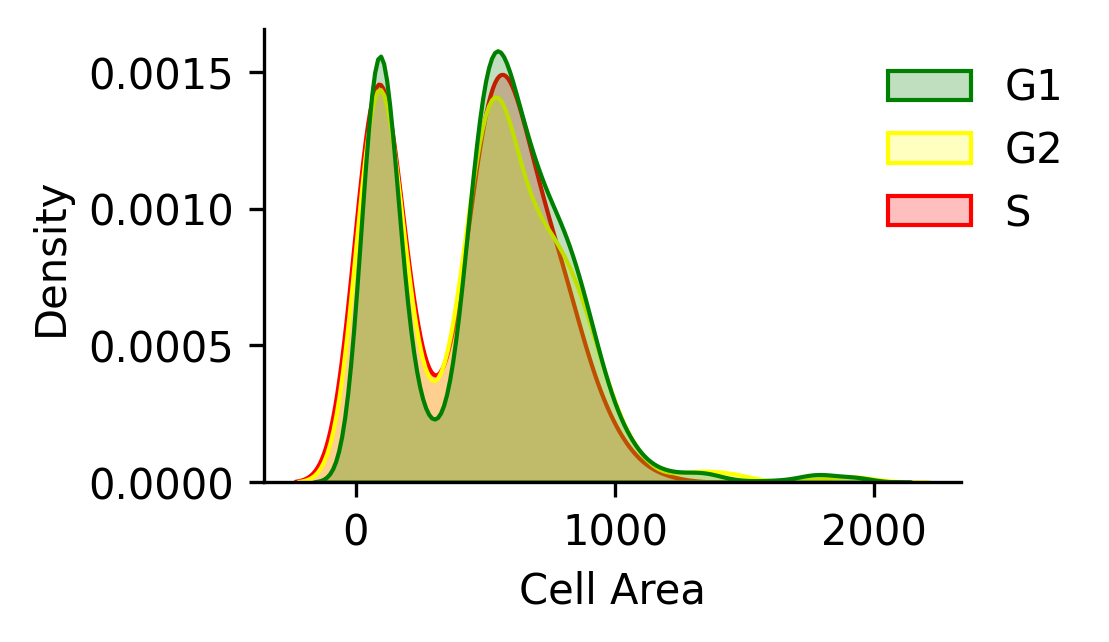

In [23]:
area_lower = 250
area_upper = 1200
pdf = cdf.copy()
pdf['phase'] = scores['phase']
pdf = pdf.reset_index(drop=True)

# pdf = pdf[(pdf['area_convex'] > area_lower) & (pdf['area_convex'] < area_upper)].reset_index(drop=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 2

sns.kdeplot(data=pdf, 
            x='area',
            hue='phase',
            common_norm=False,
            lw=1,
            palette=['green', 'yellow', 'red'],
            fill=True)

sns.move_legend(plt.gca(), 
                title="",
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.2, 1))

plt.xlabel("Cell Area")
plt.ylabel("Density")

sns.despine()

# Tracking

In [24]:
# build the segementation obeject
area_lb = 200
area_ub = 1250

pdf = cdf.copy()
pdf = pd.merge(pdf, scores, 
               how='left',
               right_on=['time', 'label'],
               left_on=['time', 'label'],)

""" FILTER CELLS """
pdf = pdf[(pdf['area'] > area_lb) & (pdf['area_convex'] < area_ub)]
# pdf = pdf[pdf['phase'].notna()]

segmentation = []

for t in pdf['time'].unique():
    tdf = pdf[pdf['time'] == t]
    
    # remove segements based on simple filter
    seg = segments[t]
    seg = np.where(np.isin(seg, tdf['label']), seg, 0)
    
    segmentation.append(seg)
    
segmentation = np.asarray(segmentation)
print(f"{segmentation.shape=}")

segmentation.shape=(49, 1329, 1801)


In [26]:
print(im.shape)

(49, 1329, 1801, 3)


In [30]:
# plt.imshow(segmentation[0, :, :], cmap='Set1_r')

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [31]:
reload(ut)

properties = ('area', )
# properties = tuple(ut.TRACKPROPS)

reload(ut)
objects = btrack.utils.segmentation_to_objects(segmentation, 
                                               intensity_image=im, 
                                               use_weighted_centroid=False,
                                               # assign_class_ID=True,
                                               properties=properties,
)

[INFO][2023/05/11 01:10:15 PM] Localizing objects from segmentation...
100%|██████████| 49/49 [00:02<00:00, 21.71it/s]
[INFO][2023/05/11 01:10:17 PM] Objects are of type: <class 'dict'>
[INFO][2023/05/11 01:10:17 PM] ...Found 4701 objects in 49 frames.


In [ ]:
FEATURES = [
  "area",
  # "major_axis_length",
  # "minor_axis_length",
  # "orientation",
  # "solidity",
]

TRACKING_UPDATES = [
  "motion",
  "visual",
]
# with btrack.BayesianTracker() as tracker:

tracker = btrack.BayesianTracker()
tracker.configure('trackerConfig.json')

# set up the features to use as a list
tracker.features = FEATURES

# append the objects to be tracked
tracker.append(objects)

tracker.track()
# tracker.track(tracking_updates=TRACKING_UPDATES)
tracker.optimize()

tracks = tracker.tracks

print(dir(tracker))

In [ ]:
def tracks_to_dataframe(tracks):
    """A function to convert tracklets to dataframe """
    return pd.concat([pd.DataFrame(x.to_dict()) for x in tracks])

tdf = tracks_to_dataframe(tracks)
print(f"{tdf.shape=}")
tdf.head()

In [ ]:
pdf = cdf.copy()
print(f"{pdf.shape=}")
pdf = pd.merge(pdf, scores, 
               how='left',
               right_on=['time', 'label'],
               left_on=['time', 'label'],)

print(f"{pdf.shape=}")


mergeCols = [
    'centroid_y',
    'centroid_x',
    # 'area',
    # 'intensity',
    # 'intensity_max',
    # 'intensity_min', 
    # 'intensity_mean',
    'label',
    'time',
    'phase',
]

tdf = pd.merge(tdf, pdf[mergeCols], 
               how='left', 
               right_on=['centroid_x', 'centroid_y', 'time'],
               left_on=['x', 'y', 't'])

print(f"{tdf.shape=}")
tdf.head()

In [ ]:
pdf = tdf.copy()

# filter the short tracks
minTrackLen = 25
pdf['trackLen'] = pdf.groupby('ID')['ID'].transform('count')
pdf = pdf[pdf['trackLen'] > minTrackLen].reset_index(drop=True)

# tid = np.random.choice(pdf['ID'], 1)[0]
# print(f"{tid=}")

# tid = 30
tid = 34

pdf = pdf[pdf['ID'] == tid].reset_index(drop=True)
pdf['area'] = pdf['area'].astype(float)
pdf = pdf.fillna("NA")


colorMap = {
    "NA" : 'lightgrey',
    "G1" : "g",
    "S" : "r",
    "G2" : "gold",
}

pdf['color'] = pdf['phase'].map(colorMap)

x = pdf['x'].values
y = pdf['y'].values

u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(1, 2, sharey=True)


axs[0].plot(x, 
         y,
         c='k', 
         zorder=0,
         lw=1,)


sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                size='area',
                c=pdf['color'].to_list(),
                linewidth=1,
                legend=False,
                ec='k',
                ax=axs[0],
                zorder=3,)

axs[0].set_ylabel("Y Position")
axs[0].set_xlabel("X Position")
axs[0].set_yticks([])
axs[0].set_xticks([])

for _x,_y,_v,_u in zip(pos_x,pos_y,v,u):
    axs[0].annotate("", 
                xytext=(_x,_y), 
                xy=(_x+0.001*_u,_y+0.001*_v), 
                arrowprops=dict(arrowstyle="->", color='k'), 
                size=7,
                zorder=2,)
    
plt.suptitle(f"Track={tid}")


# Compute the velocity vectors using finite difference
vx = np.gradient(x)
vy = np.gradient(y)
vectors = np.stack([vx, vy], axis=-1)

# Interpolate the velocity vectors onto a regular grid
nsteps = 30

grid_x, grid_y = np.meshgrid(np.linspace(np.min(x), np.max(x), nsteps), 
                             np.linspace(np.min(y), np.max(y), nsteps))


grid_vectors = interpolate.griddata((x, y), 
                                    vectors, 
                                    (grid_x, grid_y),
                                    method='linear')

axs[1].quiver(grid_x, 
              grid_y, 
              grid_vectors[:,:,0], 
              grid_vectors[:,:,1],)

axs[1].set_ylabel("")
axs[1].set_xlabel("X Position")
axs[1].set_yticks([])
axs[1].set_xticks([])

plt.tight_layout()

In [ ]:
## plot as network

pdf = tdf.copy()

tid = np.random.choice(pdf['ID'], 1)[0]
print(f"{tid=}")

# tid = 34

pdf = pdf[pdf['ID'] == tid].reset_index(drop=True)
pdf['area'] = pdf['area'].astype(float)
pdf = pdf.fillna("NA")

pdf['color'] = pdf['phase'].map(colorMap)

"""GRAPH CONSTRUCTION """
G = nx.DiGraph()
G.add_nodes_from(pdf['t'].unique())

# add edges snazzily
elist = list(zip(pdf['t'], pdf['t'].shift(-1)))
elist = elist[:-1] # drop the last edge since it's with "nan"

G.add_edges_from(elist)

# set the node attributes 
node_attr = pdf[['t', 'x', 'y', 'phase']].set_index('t').to_dict('index')
nx.set_node_attributes(G, node_attr)

# add positions
# set positions
pos = {}
for idx, row in pdf.iterrows():
    pos[row['t']] = np.array(row[['x', 'y']])
    
G.pos = pos

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 3

fig, axs = plt.subplots()

nx.draw_networkx_nodes(G,
                       pos=G.pos,
                       node_size=50,
                       node_color=pdf['color'].to_list(),
                       edgecolors='k',
                       linewidths=1,
                       ax=axs)

_ = nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=0.5,
                       edge_color='k',
                       connectionstyle="arc3,rad=0.1",
                       arrowstyle="-|>",
                       ax=axs)     

axs.set_title(f"Track={tid}")

# Vector Fields

In [ ]:
pdf = tdf.copy()

n = 50
minTrackLen = 25 # for filtering 

# filter the short tracks
pdf['trackLen'] = pdf.groupby('ID')['ID'].transform('count')
pdf = pdf[pdf['trackLen'] > minTrackLen].reset_index(drop=True)

xList = []
yList = []
vectorList = []

for tid in pdf['ID'].unique():
    vdf = pdf[pdf['ID']  == tid]
    
    x = vdf['x'].to_numpy()
    y = vdf['y'].to_numpy()
    
    vx = np.gradient(x, edge_order=2)
    vy = np.gradient(y, edge_order=2)
    
    v = np.stack([vx, vy], axis=-1)
    vectorList.append(v)
    xList.append(x)
    yList.append(y)
    
vectors = np.concatenate(vectorList)
print(f"{vectors.shape=}")
grid_x, grid_y = np.meshgrid(np.linspace(pdf['x'].min(), pdf['x'].max(), n), 
                             np.linspace(pdf['y'].min(), pdf['y'].max(), n))

grid_vectors = interpolate.griddata((np.concatenate(xList), 
                                     np.concatenate(yList)), 
                                     vectors, 
                                     (grid_x, grid_y), 
                                     method='linear')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 4

fig, axs = plt.subplots()

axs.quiver(grid_x, 
           grid_y, 
           grid_vectors[:,:,0], 
           grid_vectors[:,:,1],
           zorder=2)

gx = np.gradient(grid_vectors[:,:,0])
gy = np.gradient(grid_vectors[:,:,1])

gx = np.flipud(gx[0])
gy = np.flipud(gy[0])

mag = np.sqrt(gx**2 + gy**2)

axs.imshow(mag, 
           zorder=1, 
           extent=(pdf['x'].min(), pdf['x'].max(), 
                   pdf['y'].min(), pdf['y'].max()), 
           cmap='gnuplot2',
           alpha=0.5)

axs.set_ylabel("Y Position")
axs.set_xlabel("X Position")
_ = axs.set_xticks([])
_ = axs.set_yticks([])

In [ ]:
pdf = tdf.copy()

ncolor = 10
n = 50
minTrackLen = 20 # for filtering 

# filter the short tracks
pdf['trackLen'] = pdf.groupby('ID')['ID'].transform('count')
pdf = pdf[pdf['trackLen'] > minTrackLen].reset_index(drop=True)

phases = ['G1', 'S', 'G2']

xList = {}
yList = {}
vectorList = {}

for phase in phases:
    for tid in pdf['ID'].unique():
        vdf = pdf[(pdf['ID']  == tid) & (pdf['phase'] == phase)]
        
        if len(vdf) < 5:
            continue

        x = vdf['x'].to_numpy()
        y = vdf['y'].to_numpy()

        vx = np.gradient(x, edge_order=2)
        vy = np.gradient(y, edge_order=2)

        v = np.stack([vx, vy], axis=-1)
        
        if not phase in vectorList:
            vectorList[phase] = [v]
        else:
            vectorList[phase].append(v)
            
            
        if not phase in xList:
            xList[phase] = [x]
        else:
            xList[phase].append(x)
            
        if not phase in yList:
            yList[phase] = [y]
        else:
            yList[phase].append(y)

            
            

vectors = {k : np.concatenate(v) for k, v in vectorList.items()}

[print(f"{k=} {v.shape=}") for k, v in vectors.items()]

xmin = pdf['x'].min()
xmax = pdf['x'].max()
ymin = pdf['y'].min()
ymax = pdf['y'].max()

# meshgrid is shared
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n))

grid_vectors = {}

for phase in phases:
    grid_vectors[phase] = interpolate.griddata((np.concatenate(xList[phase]), 
                                                np.concatenate(yList[phase])), 
                                                vectors[phase], 
                                                (grid_x, grid_y), 
                                                method='linear')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

cmaps = [
    plt.cm.get_cmap("Greens", ncolor),
    plt.cm.get_cmap("Reds", ncolor),
    plt.cm.get_cmap("YlOrRd", ncolor),
]

for i, phase in enumerate(phases):
    
    gx = np.gradient(grid_vectors[phase][:,:,0])
    gy = np.gradient(grid_vectors[phase][:,:,1])
    
    gx = np.flipud(gx[0])
    gy = np.flipud(gy[0])
    
    axs[i].quiver(grid_x, 
                  grid_y, 
                  grid_vectors[phase][:,:,0], 
                  grid_vectors[phase][:,:,1],
                  zorder=2)

    mag = np.sqrt(gx**2 + gy**2)
    
    axs[i].imshow(mag, extent=(xmin, xmax, ymin, ymax), cmap=cmaps[i])
    
    if i == 0:
        axs[i].set_ylabel("Y Position")
    else:
        axs[i].set_ylabel("")

    axs[i].set_xlabel("X Position")
    _ = axs[i].set_xticks([])
    _ = axs[i].set_yticks([])
    axs[i].set_title(phase)
    

plt.tight_layout()

# Cell Cycle Smoothing

In [ ]:
# build an HMM model
G1 = Categorical([[0.7, 0.1, 0.2, 0.0001]])
S = Categorical([[0.1, 0.7, 0.20, 0.00001]])
G2 = Categorical([[0.1, 0.1, 0.8, 0.0001]])
NA = Categorical([[1/5, 1/5, 4/5, 0.0001]])

model = DenseHMM()
model.add_distributions([G1, S, G2, NA])

# init probabilites 
model.add_edge(model.start, G1, 1/3)
model.add_edge(model.start, S, 1/3)
model.add_edge(model.start, G2, 1/3)
model.add_edge(model.start, NA, 0.00001)

# transition probabilities
model.add_edge(G1, G1, 0.5)
model.add_edge(G1, S, 0.3)
model.add_edge(G1, NA, 0.00001)


model.add_edge(S, S, 0.5)
model.add_edge(S, G2, 0.4)
model.add_edge(S, NA, 0.00001)


model.add_edge(G2, G1, 0.2)
model.add_edge(G2, G2, 0.7)
model.add_edge(G2, NA, 0.00001)

# model.add_edge(NA, G1, 1/3)
# model.add_edge(NA, S, 1/3)
# model.add_edge(NA, G2, 1/3)
# model.add_edge(NA, NA, 0.00001)


phases = ['G1', 'G1', 'G1', 'S', 'G1', 'G1', "S", "S", "G1", "S", "NA", "G2"]
# phases = ['G1', 'G1', 'G1', 'S', "NA", "NA", "NA", "NA", "G1", "S", "NA", "G2"]

phaseMap = {
   "G1" :  0,
   "S" :  1,
   "G2" :  2,
   "NA" :  3,
}

phaseMapR = {
    0 :  "G1",
    1 :  "S" ,
    2 :  "G2",
    3 :  "NA",
}

sequence = [phaseMap[x] for x in phases]
X = np.array([[[x] for x in sequence]])

print(f"{X.shape=}")

y_hat = model.predict(X)

pred = [phaseMapR[y.item()] for y in y_hat[0]]

print(f"Phase {'-'.join(phases)}")
print(f"hmm pred: {'-'.join(pred)}")

In [ ]:
pdf.head()

In [ ]:
# structure the data

minTrackLen = 20 # no shorter tracks will, be used for fitting

pdf = tdf.copy()
pdf['phase'] = pdf['phase'].fillna('NA')
pdf['trackLen'] = pdf.groupby('ID')['ID'].transform('count')
pdf = pdf[pdf['trackLen'] > minTrackLen].reset_index(drop=True)

obs = []

for tLen in pdf['trackLen'].unique():

    vdf = pdf[pdf['trackLen'] == tLen].reset_index()
    print(f"{tLen=}, {len(vdf)=} {vdf['ID'].nunique()=}")
    
    # map the phases to numeric ids
    vdf['phaseId'] = vdf['phase'].map(phaseMap)
    
    tensor = vdf.groupby('ID').agg(
        phase = ('phaseId', lambda x: list(x)),
    )
    
    tensor = np.array(tensor["phase"].values.tolist())
    tensor = tensor[:, :, np.newaxis]
    obs.append(tensor)

print(f"{len(obs)=}")

model.fit(obs)
print('done')

In [ ]:
print(model.edges)

In [ ]:
predictions = []

for tid in pdf['ID'].unique():
    vdf = pdf[pdf['ID'] == tid]
    vdf = vdf.sort_values('t')
    
        
    phaseList = vdf['phase'].map(phaseMap).to_numpy()
    phaseList = phaseList[:, np.newaxis]
    
    preds = model.predict([phaseList]).tolist()[0]
    # print(preds.shape)
    predictions += preds
    

pdf['predPhase'] = [phaseMapR[x] for x in predictions]
print(len(predictions), len(pdf))    

pdf.head()

In [ ]:
fudge = 0.5 # amount expand y limit 


tid = np.random.choice(pdf['ID'])
# tid = 162
# tid = 34
# tid = 356

print(f"{tid=}")

pdx = pdf[pdf['ID'] == tid].reset_index()

print(pdx['phase'].value_counts(dropna=False))
pdx['time_in_phase'] = pdx.groupby(['ID', 'phase']).cumcount()

colorMap = {
    "G1" : 'g',
    "S" : 'r',
    "G2" : 'gold',
    "NA" : 'lightgrey',
}

pdx['color'] = pdx['phase'].map(colorMap)
pdx['pred_color'] = pdx['predPhase'].map(colorMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 3

fig, axs = plt.subplots(2, 1, sharex=True)

sns.scatterplot(data=pdx, 
                x='time',
                y='phase',
                c=pdx['color'].to_list(),
                s=25,
                marker='s',
                ec='k',
                linewidth=0.75,
                zorder=2,
                ax=axs[0])

axs[0].set_title(f'Raw PF Track ({tid})')
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].grid(True, zorder=0)
ylim = axs[0].get_ylim()
ylim = (ylim[0] + fudge, ylim[1] - fudge)
axs[0].set_ylim(ylim)

sns.scatterplot(data=pdx, 
                x='time',
                y='predPhase',
                c=pdx['pred_color'].to_list(),
                s=25,
                marker='s',
                ec='k',
                linewidth=0.75,
                zorder=2,
                ax=axs[1])

axs[1].set_title('Corrected PF Track')
axs[1].set_ylabel('')
axs[1].grid(True, zorder=0)
ylim = axs[1].get_ylim()
ylim = (ylim[0] + fudge, ylim[1] - fudge)
axs[1].set_ylim(ylim)

axs[1].set_xlabel("Time")

plt.tight_layout()

In [ ]:
phases = ['G1', 'S', 'G2']

xList = {}
yList = {}
vectorList = {}

for phase in phases:
    for tid in pdf['ID'].unique():
        vdf = pdf[(pdf['ID']  == tid) & (pdf['predPhase'] == phase)]
        
        if len(vdf) < 5:
            continue

        x = vdf['x'].to_numpy()
        y = vdf['y'].to_numpy()

        vx = np.gradient(x, edge_order=2)
        vy = np.gradient(y, edge_order=2)

        v = np.stack([vx, vy], axis=-1)
        
        if not phase in vectorList:
            vectorList[phase] = [v]
        else:
            vectorList[phase].append(v)
            
            
        if not phase in xList:
            xList[phase] = [x]
        else:
            xList[phase].append(x)
            
        if not phase in yList:
            yList[phase] = [y]
        else:
            yList[phase].append(y)

            
            

vectors = {k : np.concatenate(v) for k, v in vectorList.items()}

[print(f"{k=} {v.shape=}") for k, v in vectors.items()]

xmin = pdf['x'].min()
xmax = pdf['x'].max()
ymin = pdf['y'].min()
ymax = pdf['y'].max()

# meshgrid is shared
grid_x, grid_y = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n))

grid_vectors = {}

for phase in phases:
    grid_vectors[phase] = interpolate.griddata((np.concatenate(xList[phase]), 
                                                np.concatenate(yList[phase])), 
                                                vectors[phase], 
                                                (grid_x, grid_y), 
                                                method='linear')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 12, 4

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

cmaps = [
    plt.cm.get_cmap("Greens", ncolor),
    plt.cm.get_cmap("Reds", ncolor),
    plt.cm.get_cmap("YlOrRd", ncolor),
]

for i, phase in enumerate(phases):
    
    gx = np.gradient(grid_vectors[phase][:,:,0])
    gy = np.gradient(grid_vectors[phase][:,:,1])
    
    gx = np.flipud(gx[0])
    gy = np.flipud(gy[0])
    
    axs[i].quiver(grid_x, 
                  grid_y, 
                  grid_vectors[phase][:,:,0], 
                  grid_vectors[phase][:,:,1],
                  zorder=2)

    mag = np.sqrt(gx**2 + gy**2)
    
    axs[i].imshow(mag, extent=(xmin, xmax, ymin, ymax), cmap=cmaps[i])
    
    if i == 0:
        axs[i].set_ylabel("Y Position")
    else:
        axs[i].set_ylabel("")

    axs[i].set_xlabel("X Position")
    _ = axs[i].set_xticks([])
    _ = axs[i].set_yticks([])
    axs[i].set_title(phase)
    

plt.tight_layout()

In [ ]:
# visualize division
pdf = tdf.copy()

pdf = pdf.fillna('NA')
pdf['color'] = pdf['phase'].map(colorMap)

# get daughter cells
newCells = pdf[pdf['root'] != pdf['ID']]
did = np.random.choice(newCells['ID'])

# extract daughter track
daughter = pdf[pdf['ID'] == did]

# extract parent track
pid = daughter['root'].unique()[0]
print(f"{did=} {pid=}")
father = pdf[pdf['ID'] == pid]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 6, 6


# plot daughter
sns.scatterplot(data=daughter, 
                x='x',
                y='y',
                size='area',
                c=daughter['color'].to_list(),
                linewidth=1,
                legend=False,
                ec='k',
                zorder=3,)

ax = plt.gca()
ax.plot(daughter['x'],
        daughter['y'], 
        lw=3,
        c='b', 
        label="Daughter")

# plot father
sns.scatterplot(data=father, 
                x='x',
                y='y',
                size='area',
                c=father['color'].to_list(),
                linewidth=1,
                legend=False,
                ec='k',
                ax=ax,
                zorder=3,)

ax.plot(father['x'],
        father['y'], 
        lw=3,
        c='purple',
        label="Parent")

ax.legend(frameon=False, loc='upper right')

ax.set_title(f"Daughter {did}")

In [ ]:
break

In [ ]:
# def getPhaseSimple(cdf, quantile=0.5):
#     """must have intensities for nucleus, G1, G2 """
#     pt = pd.DataFrame(cdf["intensity_mean"].to_list(), columns=['red', 'green', 'nuc'])
    
#     rq = np.quantile(pt['red'], quantile)
#     pt['redOn'] = np.where(pt['red'] > rq, -1, 0)
    
#     gq = np.quantile(pt['green'], quantile)
#     pt['greenOn'] = np.where(pt['green'] > gq, 1, 0)
    
#     pt['phaseNum'] = pt[['redOn', 'greenOn']].sum(axis=1)
    
#     phaseMap= {
#         0 : 'G2',
#         1 : 'G1',
#         -1 : 'S',
#     }
#     phase = pt['phaseNum'].map(phaseMap)
#     return phase

# def getPhase(cdf, alpha=0.05):
#     """must have intensities for nucleus, G1, G2 """
#     cdf['intensity']
    
    
#     pt = pd.DataFrame(cdf["intensity"].to_list(), columns=['red', 'green', 'nuc'])
#     print(pt.head())

# pdf = cdf.copy()
# getPhase(pdf)
          


# area_lower = 250
# area_upper = 1250
# pdf = cdf.copy()

# pdf = pdf[(pdf['area_convex'] > area_lower) & (pdf['area_convex'] < area_upper)]


# pdf = pdf[['time', 'phase']].value_counts().reset_index()
# pdf.columns = ['time', 'phase', 'count']
# pdf = pdf.sort_values(by=['time', 'phase'])

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"
# plt.rcParams['figure.figsize'] = 6, 6

# sns.lineplot(data=pdf, 
#              x='time',
#              y='count',
#              hue='phase',
#              palette=['green', 'yellow', 'red'])

# pdf.head()